In [1]:
import matplotlib.pyplot as plt
import data
import utils

# For debugging purposes, not used by default
#%load_ext wurlitzer

# Sample visualization

**PenDigits** is a rather small dataset (<10k samples) of hand-written digits. Their apparent clusters are corresponding to the actual numbers, and we assume them to be easily distinguished.

In [2]:
# Download selected dataset
!bash data/download.sh pendigits

[1/1] Downloading: pendigits
--2019-10-13 17:17:45--  https://archive.ics.uci.edu/ml/machine-learning-databases/optdigits/optdigits.tra
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘pendigits/optdigits.tra’ not modified on server. Omitting download.

--2019-10-13 17:17:46--  https://archive.ics.uci.edu/ml/machine-learning-databases/optdigits/optdigits.tes
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘pendigits/optdigits.tes’ not modified on server. Omitting download.

pendigits/optdigits.tes is not compressed
pendigits/opt

In [3]:
## All these datasets are available for testing

# ds = data.MNIST()
# ds = data.FMNIST()
ds = data.PenDigits()
# ds = data.COIL20()
# ds = data.COIL100()
# ds = data.ScRNA()
# ds = data.Shuttle()

Ys = {}

In [4]:
print("Number of samples:", len(ds))

Number of samples: 5620


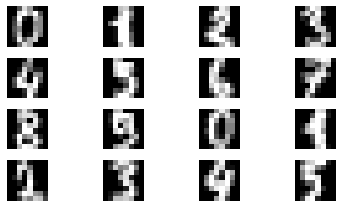

In [5]:
n_cols = 4
n_rows = 4

fig, ax = plt.subplots(n_rows, n_cols, figsize=(6, 3))
ax = ax.ravel()

for i in range(len(ax)):
    ax[i].set_axis_off()
    ax[i].imshow(ds.X[i].reshape(ds.shape), cmap="gray")

plt.tight_layout()
plt.show()

On small datasets, the time is not so critical, as long as it is less than a couple of minutes. However, even here a significant speedup can be seen. We will compare two other well-known methods with our:
 - [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)
 - [Umap](https://github.com/lmcinnes/umap)

### NCVis

In [6]:
import ncvis

vis = ncvis.NCVis(distance='correlation')

In [7]:
%%time
Ys['ncvis'] = vis.fit_transform(ds.X)

CPU times: user 5.1 s, sys: 17.5 ms, total: 5.11 s
Wall time: 432 ms


### Umap

In [8]:
from umap import UMAP

umap = UMAP(metric='correlation')

In [9]:
%%capture --no-stdout
%%time
Ys['umap'] = umap.fit_transform(ds.X)

CPU times: user 12.2 s, sys: 29.4 ms, total: 12.2 s
Wall time: 10.4 s


### t-SNE

In [10]:
from sklearn.manifold import TSNE

tsne = TSNE()

In [11]:
%%time
Ys['tsne'] = tsne.fit_transform(ds.X)

CPU times: user 31.6 s, sys: 49.6 ms, total: 31.7 s
Wall time: 28.9 s


## Pictures

**NCVis** captures the cluster structure, while not collapsing the clusters. Such behavior is desired for those who are used to t-SNE. **Umap**, however, makes it more simple for clustering algorithms to discover groups of points.

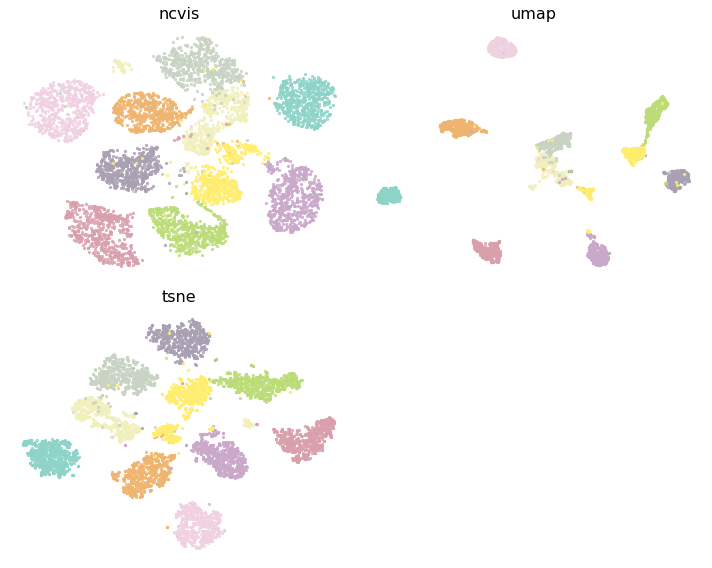

In [12]:
n_cols = 2
n_imgs = len(Ys.items())
n_rows = (n_imgs+n_cols-1)//n_cols 

fig, ax = plt.subplots(n_rows, n_cols, figsize=(10, 8))
ax = ax.ravel()

for k, (name, Y) in enumerate(Ys.items()):
    ax[k].set_title(name, fontsize=16)
    ax[k].set_axis_off()
    utils.scatter_classes(Y, ds.y, ax[k], marker='.', s=20, alpha=0.8,
                          show_labels=False)
while k < n_imgs:
    k += 1
    ax[k].set_axis_off()
    
plt.tight_layout()
plt.show()

In [13]:
fig.savefig("img/pendigits.pdf")

# Data Mining

Let's take a look at a beautiful problem that can be solved with such a method with minimal effort. Consider we have a set of pictures, each provided with one sentence description of their contents. How can we tell, which words do look similarily?

We propose to do the following: for the set of sentences $\{s_i\}_{i=1}^N$ and words $\{w_k\}_{k=1}^K$ create binary vectors $\{\mathbf{v}_k\}_{k=1}^K$, $\mathbf{v}_k \in \{0, 1\}^N$. If word $w_k$ can be found on the description of image $s_i$, we set $\mathbf{v}_k(i) = 1$; otherwise, we set $\mathbf{v}_k(i) = 0$.

Intuitively,  visualization will try to place similarly looking words close to each other. It happens, as such words correspond to the nearly same set of pictures by construction and, thus, their binary vectors have much in common.

We will use [Multi30k](https://github.com/multi30k/dataset) dataset. Let's download it:

In [1]:
import os
data_dir = "big-data"
url = "https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/tok/train.lc.norm.tok.en"
save_to = os.path.join(data_dir, os.path.basename(url))

!mkdir -p $data_dir
!wget -nc $url -O $save_to

--2019-12-18 16:48:58--  https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/tok/train.lc.norm.tok.en
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.244.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.244.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1837696 (1.8M) [text/plain]
Saving to: ‘big-data/train.lc.norm.tok.en’

big-data/train.lc.n 100%[===================>]   1.75M  1.30MB/s    in 1.3s    

2019-12-18 16:49:00 (1.30 MB/s) - ‘big-data/train.lc.norm.tok.en’ saved [1837696/1837696]



Define some language preprocessing functions:

In [2]:
import unicodedata
import re
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \n", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s.strip()

def read_sentences(path):
    lines = []
    with open(path) as f:
        for line in f:
            lines.append(normalizeString(line))
    return lines

Finally, read the dataset:

In [3]:
lines = read_sentences(save_to)

Build the encoding we have discussed above:

In [4]:
import numpy as np
n_words = 0
n_lines = len(lines)
word2index = {}
word2count = {}
index2word = []
index2vec = []

for i in range(n_lines):
    for word in lines[i].split(' '):
        if word not in word2index:   
            word2index[word] = n_words
            word2count[word] = 1
            index2word.append(word)
            vec = np.zeros(n_lines)
            vec[i] = 1
            index2vec.append(vec)
            n_words += 1
        else:
            word2count[word] += 1
            index2vec[word2index[word]][i] = 1

index2vec = np.array(index2vec)
# Drop rare words
mask = index2vec.sum(axis=1) > 10
new_inds = np.arange(index2vec.shape[0], dtype=int)[mask]
index2vec = index2vec[mask, :]
index2count = np.array([word2count[w] for w in index2word])
index2count = index2count[mask]
print("Total number of words:", index2vec.shape[0])
print("Total number of descriptions:", index2vec.shape[1])

Total number of words: 1948
Total number of descriptions: 29000


Use **NCVis** to construct the visualization:

In [5]:
import ncvis

vis = ncvis.NCVis(distance='correlation')

In [6]:
%%time
Ys = vis.fit_transform(index2vec)

CPU times: user 2min 12s, sys: 753 ms, total: 2min 13s
Wall time: 19.3 s


In [10]:
# Number of words to display
n_top = 1948

top_inds = np.argsort(index2count)[-n_top:][::-1]
top_words = [index2word[new_inds[ind]] for ind in top_inds]
weights = index2count/index2count.max()

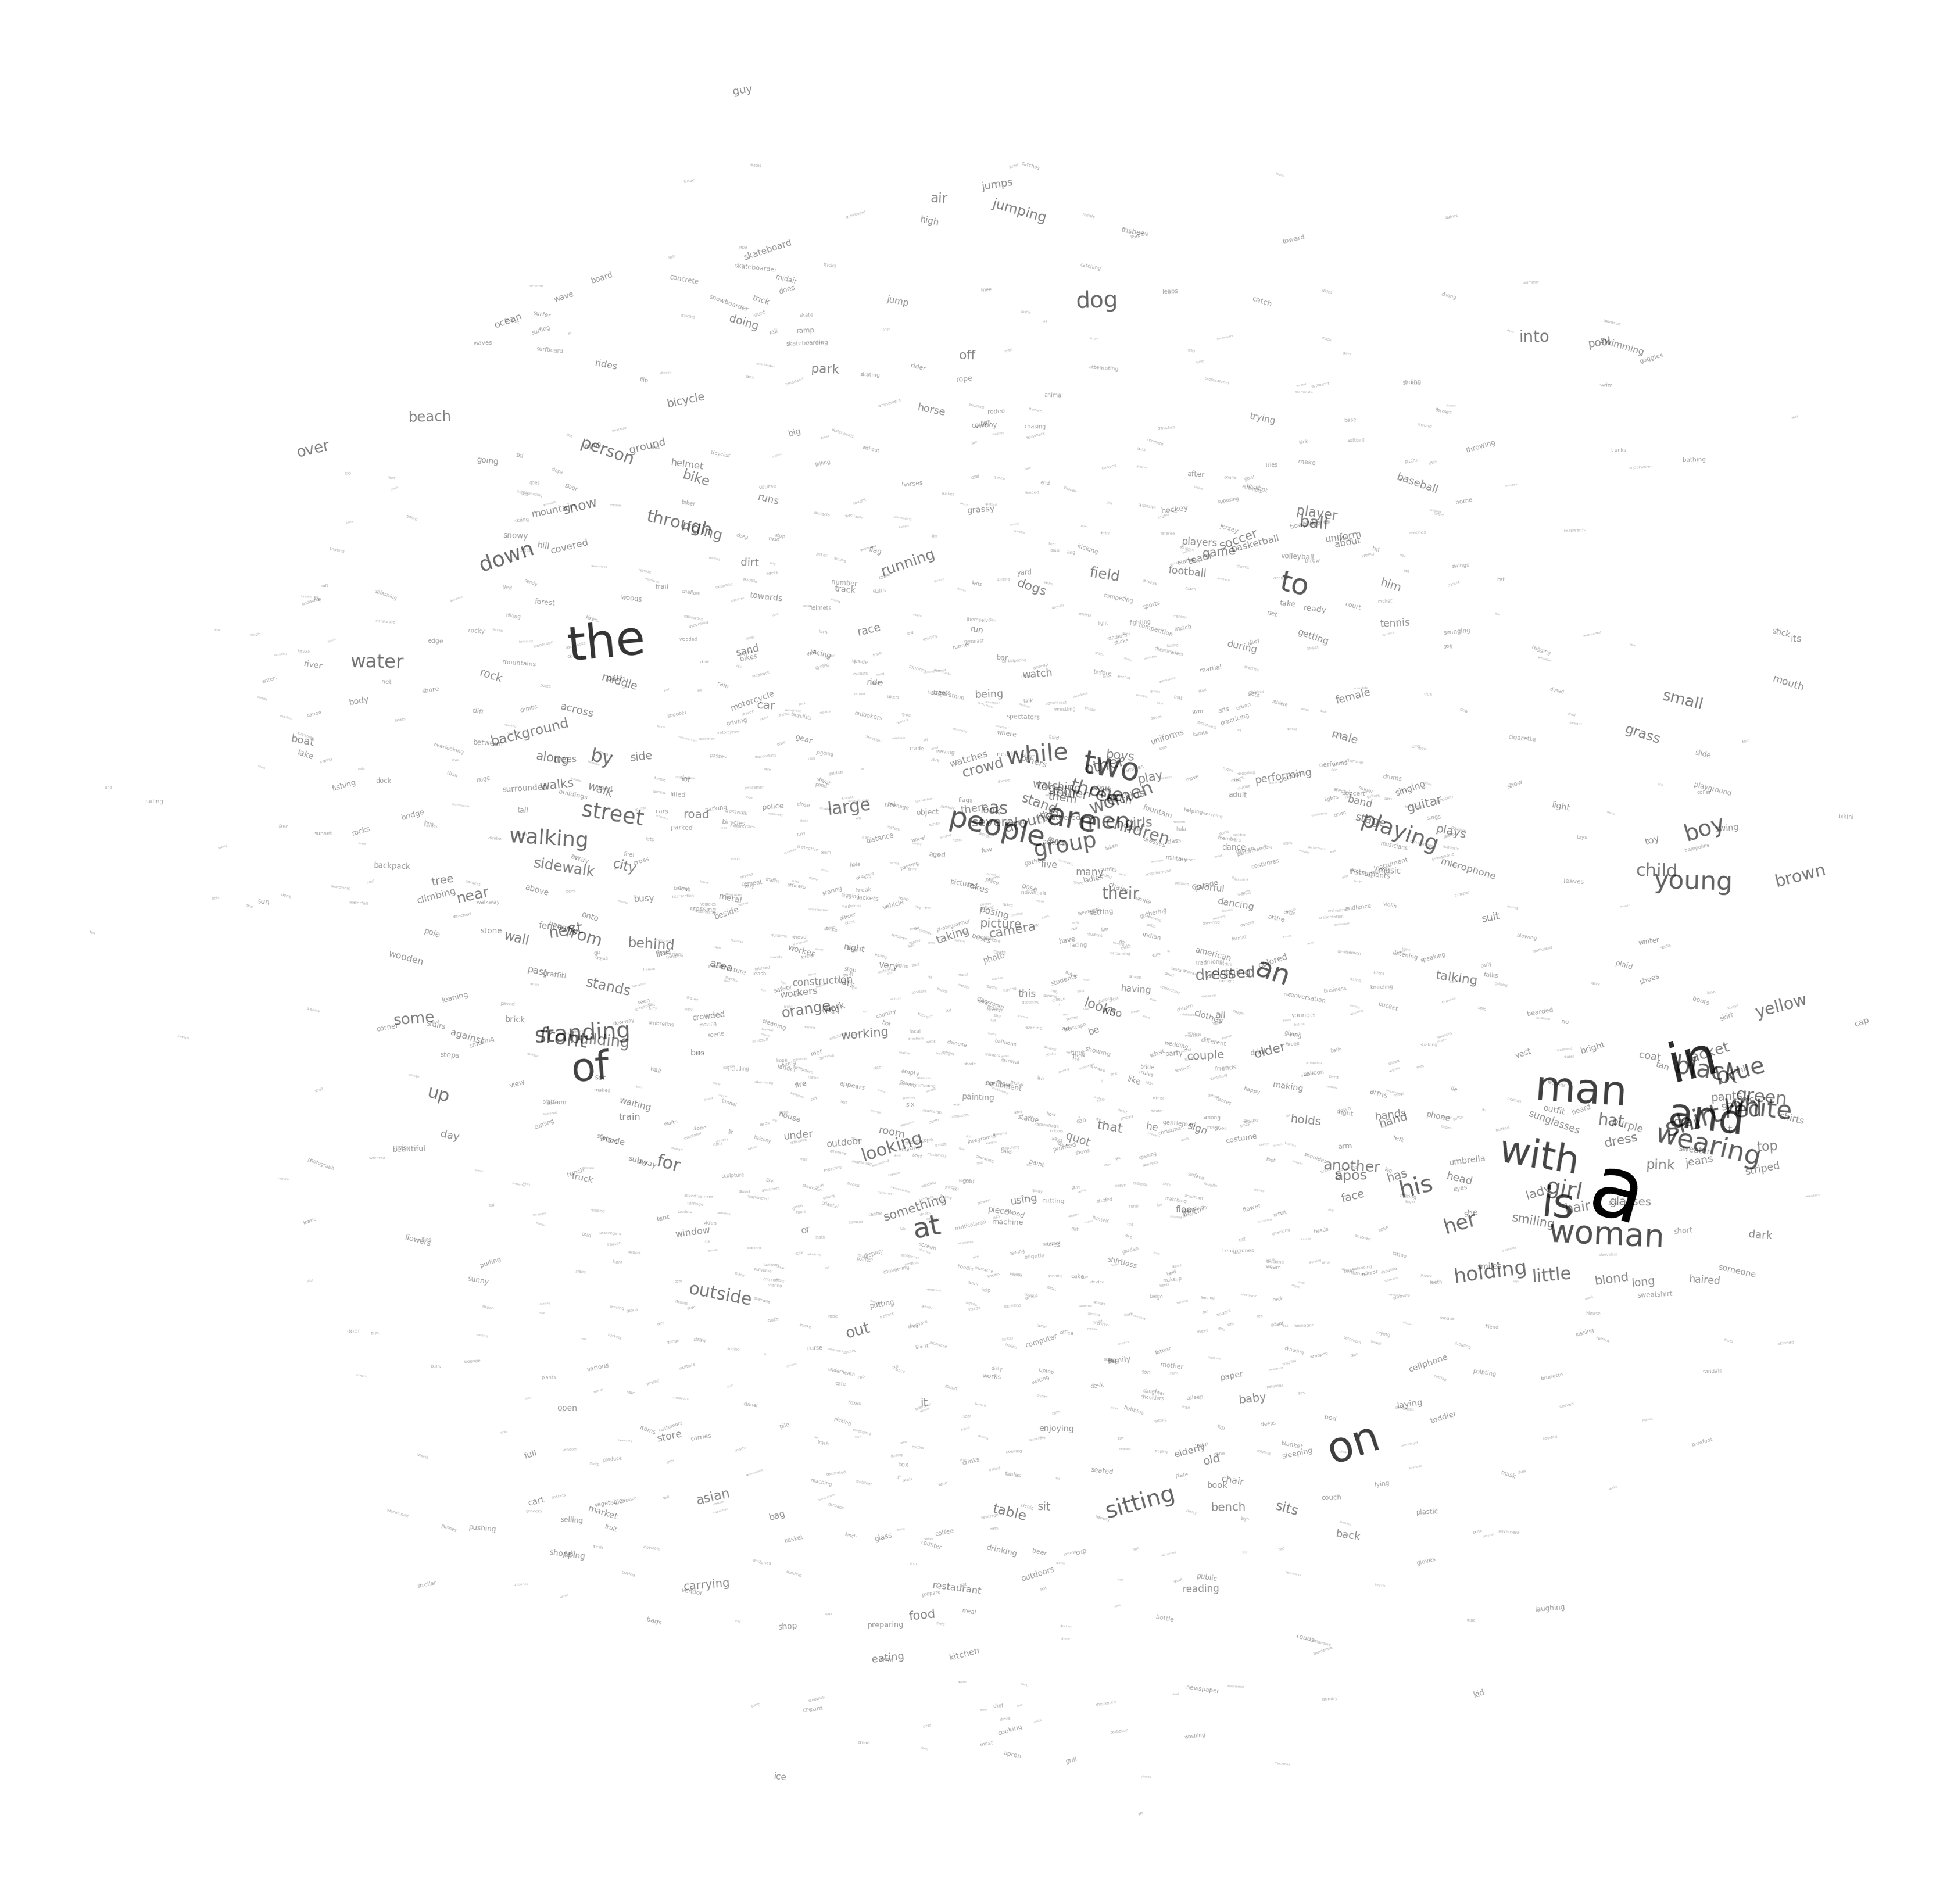

In [11]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(60, 60))

ax.set_axis_off()
ax.scatter(Ys[:, 0], Ys[:, 1], s=500*weights, alpha=0)
for ind in top_inds:
    ax.text(Ys[ind, 0], Ys[ind, 1], index2word[new_inds[ind]], horizontalalignment='center', verticalalignment='center', 
            fontsize=150*weights[ind]**0.4, alpha=weights[ind]**0.15, stretch='condensed', rotation=np.random.uniform(-1, 1)*20)
plt.show()

We can save the picture (.jpg leads to quality drop, but saves space):

In [12]:
fig.savefig('img/words.jpg')